In [82]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 56.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from captum.attr import GradientShap



In [130]:
df = pd.read_csv("economics.csv")

In [131]:
# Normalize only the features (X) and target (y) separately
feature_cols = ['pop', 'psavert', 'uempmed', 'unemploy']
target_col = 'pce'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[[target_col]])

# Create input-output sequences
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:i+seq_length]  # features up to time t-1
        y_val = y[i + seq_length]  # target at time t
        xs.append(x_seq)
        ys.append(y_val)
    return np.array(xs), np.array(ys)

seq_length = 12  # one year of past data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

print("X_seq shape:", X_seq.shape)  # (samples, seq_length, num_features)
print("y_seq shape:", y_seq.shape)  # (samples, 1)


X_seq shape: (562, 12, 4)
y_seq shape: (562, 1)


In [132]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)               # out: (batch, seq_len, hidden)
        out = out[:, -1, :]                 # get output from last time step
        out = self.fc(out)                  # map to output
        return out


In [133]:
# Set input/output dimensions based on your data
input_size = X_seq.shape[2]   # 4 features
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting 1 value: next period's pce

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [134]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Split the dataset
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [135]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [136]:
batch_size = 32

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [137]:
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/50, Loss: 1.2623
Epoch 2/50, Loss: 0.4946
Epoch 3/50, Loss: 0.2361
Epoch 4/50, Loss: 0.0256
Epoch 5/50, Loss: 0.0093
Epoch 6/50, Loss: 0.0088
Epoch 7/50, Loss: 0.0076
Epoch 8/50, Loss: 0.0174
Epoch 9/50, Loss: 0.0067
Epoch 10/50, Loss: 0.0069
Epoch 11/50, Loss: 0.0062
Epoch 12/50, Loss: 0.0075
Epoch 13/50, Loss: 0.0073
Epoch 14/50, Loss: 0.0080
Epoch 15/50, Loss: 0.0055
Epoch 16/50, Loss: 0.0068
Epoch 17/50, Loss: 0.0058
Epoch 18/50, Loss: 0.0059
Epoch 19/50, Loss: 0.0070
Epoch 20/50, Loss: 0.0054
Epoch 21/50, Loss: 0.0045
Epoch 22/50, Loss: 0.0051
Epoch 23/50, Loss: 0.0068
Epoch 24/50, Loss: 0.0123
Epoch 25/50, Loss: 0.0081
Epoch 26/50, Loss: 0.0053
Epoch 27/50, Loss: 0.0050
Epoch 28/50, Loss: 0.0043
Epoch 29/50, Loss: 0.0043
Epoch 30/50, Loss: 0.0036
Epoch 31/50, Loss: 0.0044
Epoch 32/50, Loss: 0.0058
Epoch 33/50, Loss: 0.0105
Epoch 34/50, Loss: 0.0097
Epoch 35/50, Loss: 0.0054
Epoch 36/50, Loss: 0.0098
Epoch 37/50, Loss: 0.0041
Epoch 38/50, Loss: 0.0031
Epoch 39/50, Loss: 0.

In [138]:
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        actuals.append(targets.numpy())

# Stack and reshape
predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Reverse normalization
predictions_rescaled = scaler_y.inverse_transform(predictions)
actuals_rescaled = scaler_y.inverse_transform(actuals)


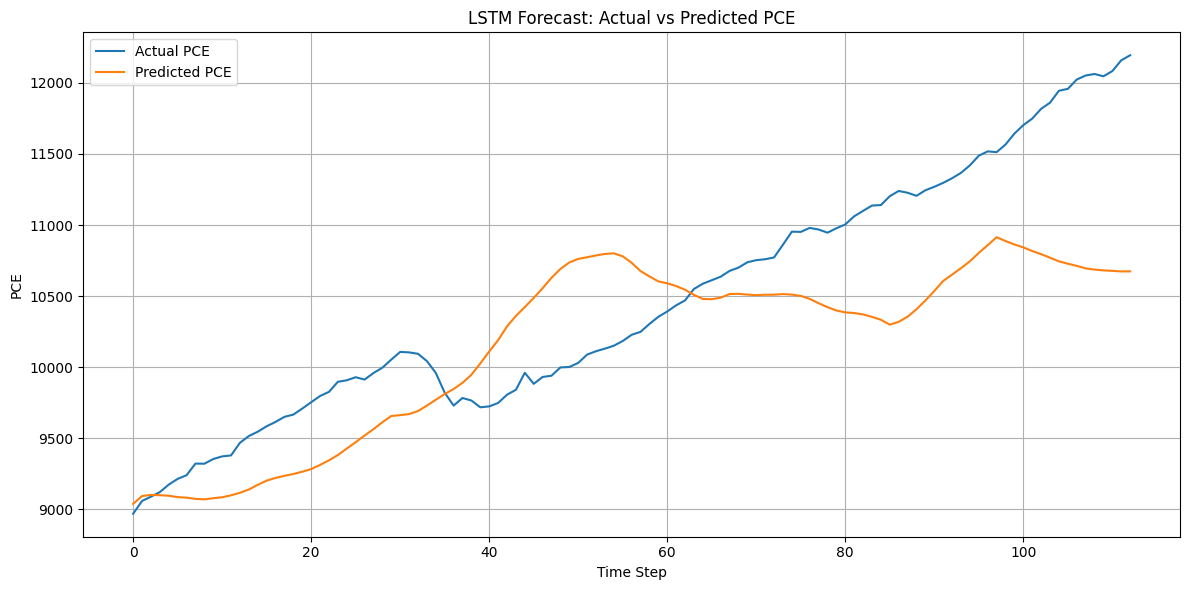

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled, label="Actual PCE")
plt.plot(predictions_rescaled, label="Predicted PCE")
plt.legend()
plt.title("LSTM Forecast: Actual vs Predicted PCE")
plt.xlabel("Time Step")
plt.ylabel("PCE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [140]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Root Mean Squared Error (RMSE): 629.33


GradientSHAP vs CASh

In [141]:
#We’ll explain a single prediction (or a small batch) from the test set.
# Get a batch from the test dataset
sample_input, sample_target = test_dataset[0]
sample_input = sample_input.unsqueeze(0)  # shape: (1, seq_len, num_features)


Set up a wrapper to extract attribution just for psavert, We extract attribution per time step for only psavert, which is feature index 1 in our inputs.

In [142]:
from captum.attr import GradientShap

# Prepare the baseline (zero input, or mean input)
baseline_dist = torch.zeros_like(sample_input)

# Initialize GradientShap with your model
gshap = GradientShap(model)

# Run GradientSHAP
attributions, delta = gshap.attribute(
    sample_input,
    baselines=baseline_dist,
    target=0,  # predicting a scalar value
    return_convergence_delta=True
)


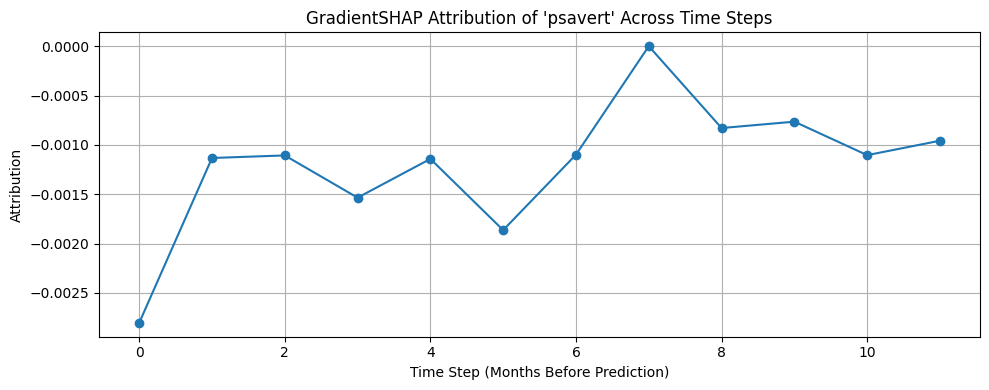

In [143]:
# Get attribution only for psavert (index 1)
psavert_attribution = attributions[0, :, 1].detach().numpy()  # shape: (sequence_len,)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(len(psavert_attribution)), psavert_attribution, marker='o')
plt.title("GradientSHAP Attribution of 'psavert' Across Time Steps")
plt.xlabel("Time Step (Months Before Prediction)")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()


In [144]:
def compute_cash_attributions(model, input_tensor, baseline_tensors, feature_index, n_steps=50):
    model.eval()
    input_tensor = input_tensor.requires_grad_(True)
    seq_len = input_tensor.shape[1]
    num_features = input_tensor.shape[2]

    total_attr = torch.zeros(seq_len).to(input_tensor.device)
    alphas = torch.linspace(0.0, 1.0, steps=n_steps).view(n_steps, 1, 1, 1).to(input_tensor.device)

    for baseline in baseline_tensors:
        if baseline.ndim == 2:
            baseline = baseline.unsqueeze(0)
        baseline = baseline.to(input_tensor.device)
        assert baseline.shape == input_tensor.shape, f"Mismatch: baseline {baseline.shape}, input {input_tensor.shape}"

        delta = input_tensor - baseline
        scaled_inputs = baseline + alphas * delta  # shape: (n_steps, 1, seq_len, num_features)
        scaled_inputs = scaled_inputs.requires_grad_(True)

        flat_inputs = scaled_inputs.view(-1, seq_len, num_features)
        preds = model(flat_inputs)

        grads = torch.autograd.grad(
            outputs=preds,
            inputs=scaled_inputs,
            grad_outputs=torch.ones_like(preds),
            create_graph=False,
            retain_graph=False
        )[0]  # (n_steps, 1, seq_len, features)

        grads_feature = grads[:, 0, :, feature_index]  # (n_steps, seq_len)

        # 🔧 Safely extract the time series for the selected feature
        input_seq = input_tensor[0]    # shape: (seq_len, features)
        baseline_seq = baseline[0]     # shape: (seq_len, features)
        diff_feature = input_seq[:, feature_index] - baseline_seq[:, feature_index]  # shape: (seq_len,)

        # Debug print (optional)
        print("diff_feature shape:", diff_feature.shape)
        print("avg_grads shape:", grads_feature.mean(dim=0).shape)

        avg_grads = grads_feature.mean(dim=0)  # (seq_len,)
        attr = avg_grads * diff_feature        # element-wise
        total_attr += attr.detach()

    return (total_attr / len(baseline_tensors)).cpu().numpy()


In [145]:
sample_input = X_test[0].unsqueeze(0)  # shape: (1, seq_len, num_features)
baseline_tensors = [X_train[i].unsqueeze(0) for i in np.random.choice(len(X_train), 10, replace=False)]
psavert_index = feature_cols.index('psavert')


In [146]:
cash_attr = compute_cash_attributions(
    model=model,
    input_tensor=sample_input,
    baseline_tensors=baseline_tensors,
    feature_index=psavert_index,
    n_steps=50
)

diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])
diff_feature shape: torch.Size([12])
avg_grads shape: torch.Size([12])


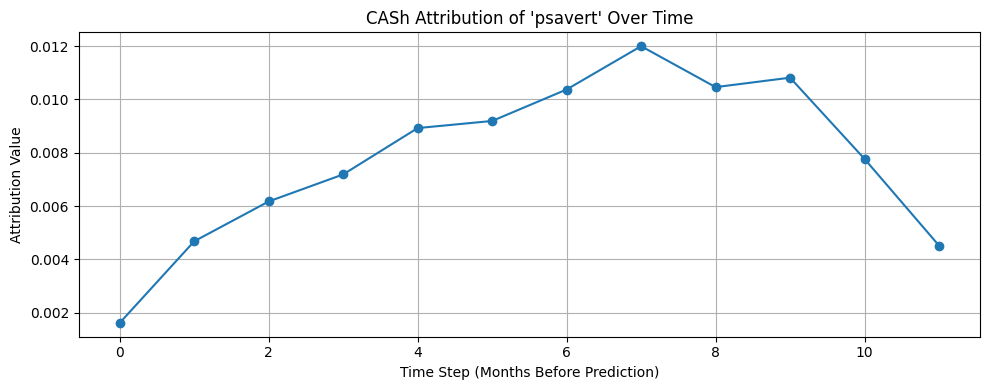

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(len(cash_attr)), cash_attr, marker='o')
plt.title("CASh Attribution of 'psavert' Over Time")
plt.xlabel("Time Step (Months Before Prediction)")
plt.ylabel("Attribution Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [148]:
def compute_cash_feature_totals(model, input_tensor, baseline_tensors, n_steps=50):
    """
    Returns: CASh scalar attribution for each feature (aggregated across time)
    """
    model.eval()
    input_tensor = input_tensor.requires_grad_(True)
    seq_len, num_features = input_tensor.shape[1:]

    total_attr = torch.zeros(num_features).to(input_tensor.device)
    alphas = torch.linspace(0.0, 1.0, steps=n_steps).view(n_steps, 1, 1, 1).to(input_tensor.device)

    for baseline in baseline_tensors:
        if baseline.ndim == 2:
            baseline = baseline.unsqueeze(0)
        baseline = baseline.to(input_tensor.device)
        assert baseline.shape == input_tensor.shape

        delta = input_tensor - baseline
        scaled_inputs = baseline + alphas * delta  # shape: (n_steps, 1, seq_len, features)
        scaled_inputs = scaled_inputs.requires_grad_(True)

        flat_inputs = scaled_inputs.view(-1, seq_len, num_features)
        preds = model(flat_inputs)

        grads = torch.autograd.grad(
            outputs=preds,
            inputs=scaled_inputs,
            grad_outputs=torch.ones_like(preds),
            create_graph=False,
            retain_graph=False
        )[0]  # (n_steps, 1, seq_len, features)

        avg_grads = grads.mean(dim=0)[0]               # shape: (seq_len, features)
        diff = (input_tensor[0] - baseline[0])         # shape: (seq_len, features)
        attr = (avg_grads * diff).sum(dim=0)           # sum over time → (features,)
        total_attr += attr.detach()

    return (total_attr / len(baseline_tensors)).cpu().numpy()  # shape: (features,)


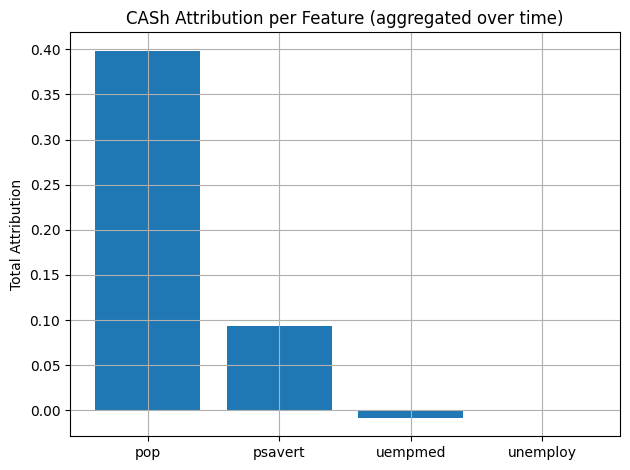

In [149]:
cash_per_feature = compute_cash_feature_totals(
    model=model,
    input_tensor=sample_input,
    baseline_tensors=baseline_tensors,
    n_steps=50
)

# Display as bar chart
import matplotlib.pyplot as plt

plt.bar(feature_cols, cash_per_feature)
plt.title("CASh Attribution per Feature (aggregated over time)")
plt.ylabel("Total Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()
